In [2]:
import os
import sys
import glob
import pickle
sys.path.append('../metanas')

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import matplotlib
from metanas.utils.visualize import plot
from IPython.display import Image, display, Markdown

matplotlib.rcParams['font.serif'] = ['CMU Serif Roman']

In [70]:
def get_experiment_pickle(base_path, path):
    result = []
    path = os.path.join(base_path, path)
    for p in glob.glob(f"{path}/*/experiment.pickle"):
        with (open(p, 'rb')) as f:
            res = pickle.load(f)
            result.append(res)
    return result

def plot_accuracy_loss_multiple_seeds(base_path, paths, labels, eval_every,
                                      title="", draw_warm_up=False):
    """Plot all the results in one overview"""

    def plot_line_training(ax, result, indice, label, y_label):
        train_acc = np.array([np.array(m[indice]) for m in result])

        len_epoch = len(np.array(result[0][indice]))
        train_acc_mean = train_acc.mean(axis=0)
        train_acc_std = train_acc.std(axis=0)
        x_axis_meta = np.array(range(train_acc_mean.shape[0]))
        
        ax.plot(x_axis_meta, train_acc_mean, lw = 2, alpha = 1, label=label)
        
        ax.set_title(f"Meta-training {y_label}")
        ax.fill_between(x_axis_meta, train_acc_mean - train_acc_std,
                        train_acc_mean + train_acc_std, alpha = 0.4)
        ax.set_xlabel("epoch")
        ax.set_ylabel(y_label)
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc="best")
    
    def plot_line_test(ax, result, indice, label, y_label, eval_every):
        test_spacing = np.linspace(
            eval_every, eval_every*len(result[0][indice]),
            num=len(result[0][indice]), retstep=eval_every,
            dtype=np.int32
        )[0]

        train_acc = np.array([np.array(m[indice]) for m in result])

        len_epoch = len(np.array(result[0][indice]))
        train_acc_mean = train_acc.mean(axis=0)
        train_acc_std = train_acc.std(axis=0)
        
        ax.plot(test_spacing[:len(result[0][indice])],
                train_acc_mean, lw = 2,
                alpha = 1, label=label)
        
        ax.set_title(f"Meta-testing {y_label}")
        ax.fill_between(test_spacing[:len(result[0][indice])],
                        train_acc_mean - train_acc_std,
                        train_acc_mean + train_acc_std, alpha = 0.4)
        ax.set_xlabel("epoch")
        ax.set_ylabel(y_label)
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc="best")
    
    results = [get_experiment_pickle(base_path, p) for p in paths]
    
    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    plt.suptitle(title, fontsize=14)
    
    
    # ax[0].axvline(x=250, color="gray", linestyle="--", label="End of warm up")
    # ax.axvline(x=250, color="gray", linestyle="--", label="End of warm up")
    y_label = ["acurracy", "loss"]
    if draw_warm_up:
        for i, _ in enumerate(results):
            for j, _ in enumerate(["train_test_accu", "train_test_loss"]):
                ax[i,j].axvline(x=250, linestyle="dashed", label="Warm-up phase ends", c='gray')
    
    for i, res in enumerate(results):
        for j, indice in enumerate(["train_test_accu", "train_test_loss"]):
            plot_line_training(ax[j, 0], res, indice, labels[i], y_label=y_label[j])
        
        for j, indice in enumerate(["test_test_accu", "test_test_loss"]):
            plot_line_test(ax[j, 1], res, indice, labels[i], y_label=y_label[j], eval_every=eval_every[i])

0 ['MetaNAS']
MetaNAS


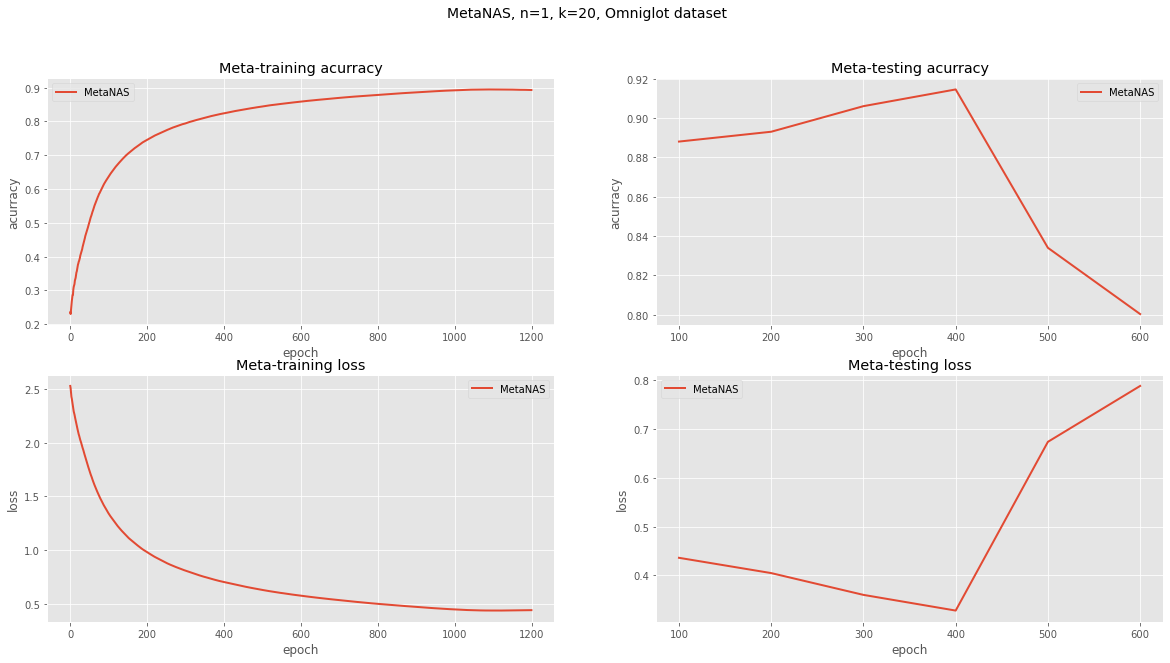

In [34]:
base_path = '/home/rob/Desktop/results'

paths = ["ablation/omniglot_train_metanas_epoch"]
names = ["MetaNAS"]

plot_accuracy_loss_multiple_seeds(base_path, paths, names, eval_every=[100], title="MetaNAS, n=1, k=20, Omniglot dataset")

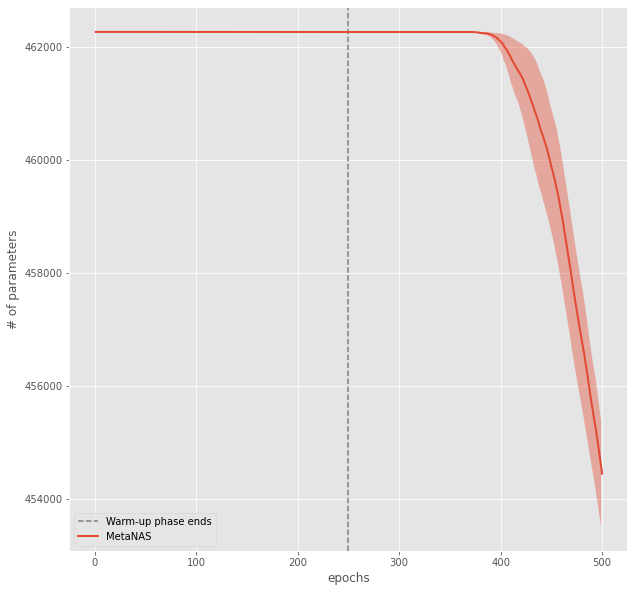

In [40]:
b_path = "/home/rob/Git/meta-fsl-nas/metanas/results/ablation"
pa = ["omniglot_train_metanas_w_param"]


plt.figure(figsize=(10,10))

def plot_number_of_params(base_path, paths, indice="train_test_params", label="MetaNAS", x_warm_up=250):
    results = [get_experiment_pickle(base_path, p) for p in paths]

    plt.axvline(x=x_warm_up, linestyle="dashed", label="Warm-up phase ends", c='gray')
    
    for i, result in enumerate(results):
        train_acc = np.array([np.array(m[indice]) for m in result])
        train_acc_mean = train_acc.mean(axis=0)
        train_acc_std = train_acc.std(axis=0)

        x_axis_meta = np.array(range(train_acc_mean.shape[0]))
        

        plt.plot(np.arange(1, 501),
                train_acc_mean, lw = 2,
                alpha = 1, label=label)

        plt.fill_between(x_axis_meta,
                        train_acc_mean - train_acc_std,
                        train_acc_mean + train_acc_std, alpha = 0.4)
        plt.ylabel("# of parameters")
        plt.xlabel("epochs")
        plt.legend()

# The meta-training contains less adaptation steps than meta-testing
plot_number_of_params(b_path, pa)

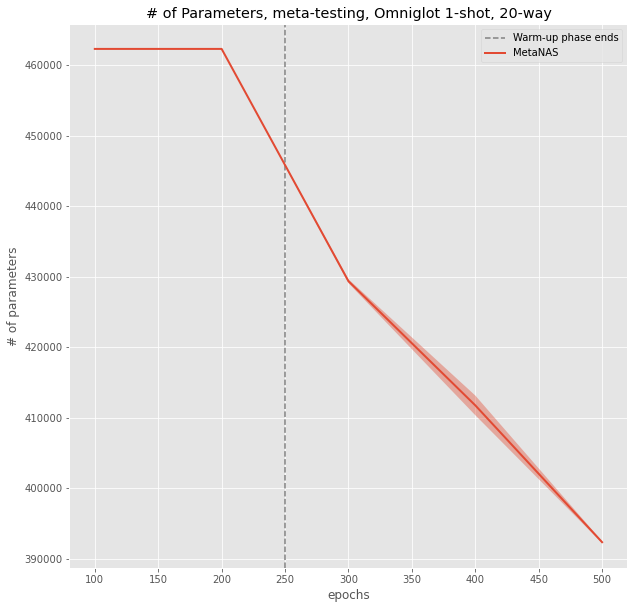

In [63]:
pa = ["omniglot_train_metanas_w_param"]
    
plt.figure(figsize=(10,10))

def plot_meta_testing_params(base_path, paths, indice="train_test_params", label="MetaNAS"):
    results = [get_experiment_pickle(base_path, p) for p in paths]


    plt.axvline(x=250, linestyle="dashed", label="Warm-up phase ends", c='gray')
    
    
    for i, result in enumerate(results):
        x_axis_meta = np.linspace(
            100, 100*len(result[0][indice]),
            num=len(result[0][indice]), retstep=100,
            dtype=np.int32)[0]
        
        train_acc = np.array([np.array(m[indice]) for m in result])
        train_acc_mean = train_acc.mean(axis=0)
        train_acc_std = train_acc.std(axis=0)

        plt.title("# of Parameters, meta-testing, Omniglot 1-shot, 20-way")

        plt.plot(x_axis_meta,
                train_acc_mean, lw = 2,
                alpha = 1, label=label)

        plt.fill_between(x_axis_meta,
                        train_acc_mean - train_acc_std,
                        train_acc_mean + train_acc_std, alpha = 0.4)
        plt.ylabel("# of parameters")
        plt.xlabel("epochs")
        plt.legend()

# The meta-training contains less adaptation steps than meta-testing,
# hence, the model is more sparse here. As more adaptation steps are used.
plot_meta_testing_params(b_path, pa, indice="test_test_params")

In [28]:
# TODO: Add parsing for seperate meta-testing, meta-training
# TODO: Add parsing graphs for MetaNAS + RL (CSV)

# Ablation plots - Omniglot 1-shot, 20-way
---

### MetaNAS (baseline)

| 1-shot, 20-way Omniglot |   |
|-------------------------|---|
| **Seed 0**              |   |
| Metanas	          | **x** |
| **Seed 1**              |   |
| Metanas  	          | **x** |

In [59]:
base_path = "/home/rob/Git/meta-fsl-nas/metanas/results/ablation"

paths_sharp = [
    "omniglot_train_metanas",
    "omniglot_train_metanas_large",
    "omniglot_train_metanas_w_param",
]

names_sharp = [
    "MetaNAS",
    "MetaNAS",
    "MetaNAS"
    
]

# plot_accuracy_loss_multiple_seeds(base_path, paths_sharp, names_sharp, eval_every=[100, 100, 100],
#                    title="Ablation study, n=1, k=20, Omniglot dataset")

### SharpDARTS

| 1-shot, 20-way Omniglot |   |   |   |   |   |   |   |
|-------------------------|---|---|---|---|---|---|---|
| **Seed 0**              |   |   |   |   |   |   |   |
| Alpha Regularization    | - | x | x |   | x |   |   |
| Power Cosine Annealing  | - | x |   | x |   | x |   |
| SharpDARTS Search Space | - |   | x | x |   |   | x |
| **Seed 1**              |   |   |   |   |   |   |   |
| Alpha Regularization    | - | x | x |   | x |   |   |
| Power Cosine Annealing  | - | x |   | x |   | x |   |
| SharpDARTS Search Space | - |   | x | x |   |   | x |


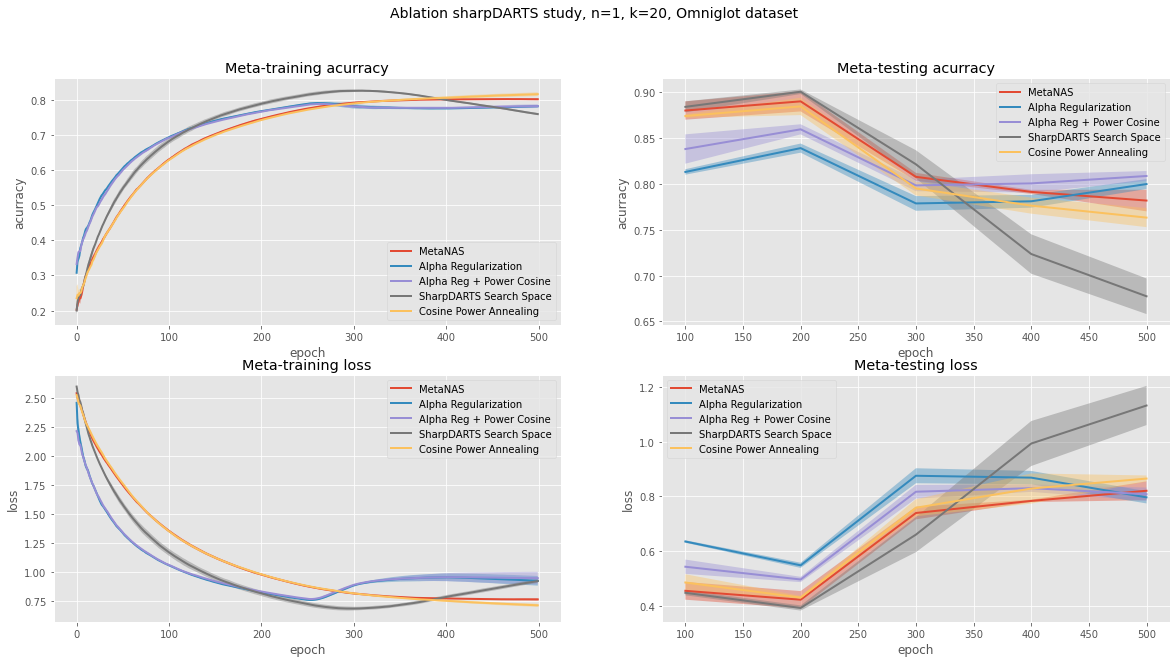

In [60]:
paths_sharp = [
    "omniglot_train_metanas",
#     "omniglot_train_sharp",
    "omniglot_train_alpha_reg",
    "omniglot_train_alpha_reg_power_cosine",
    "omniglot_train_ss_sharp",
#     "omniglot_train_ss_harp_alpha_reg",
    "omniglot_train_power_cosine",
]

names_sharp = [
    "MetaNAS",
#     "SharpDARTS",
    "Alpha Regularization",
    "Alpha Reg + Power Cosine",
    "SharpDARTS Search Space",
#     "SS Sharp + Alpha Reg",
    "Cosine Power Annealing",
]

plot_accuracy_loss_multiple_seeds(base_path, paths_sharp, names_sharp, eval_every=[100, 100, 100, 100, 100],
                   title="Ablation sharpDARTS study, n=1, k=20, Omniglot dataset")

### P-DARTS

| 1-shot, 20-way Omniglot      |   |   |   |
|------------------------------|---|---|---|
| **Seed 0**                   |   |   |   |
| Search Space Approximation   | x | x |   |
| Search Space Regularization  | x |   | x |
| **Seed 1**                   |   |   |   |
| Search Space Approximation   | x | x |   |
| Search Space Regularization  | x |   | x |

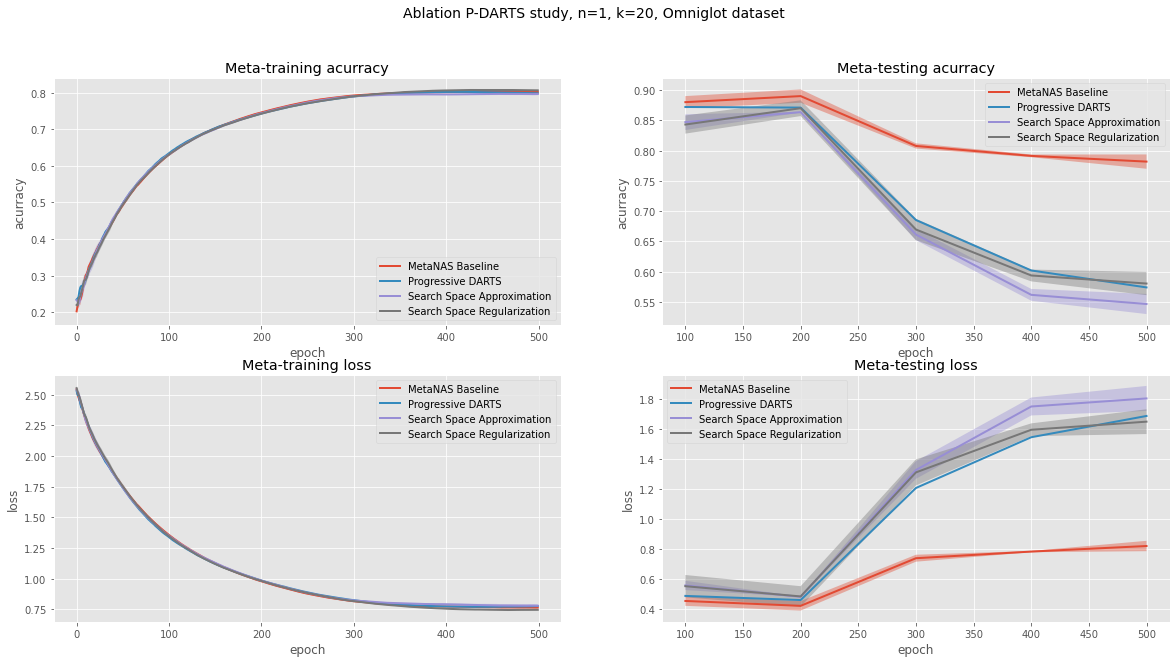

In [61]:
paths = [
    "omniglot_train_metanas",
    "omniglot_train_pdarts",
    "omniglot_train_ssa",
    "omniglot_train_ssr",
]

names = [
    "MetaNAS Baseline",
    "Progressive DARTS",
    "Search Space Approximation",
    "Search Space Regularization"
]


plot_accuracy_loss_multiple_seeds(base_path, paths, names, eval_every=[100, 100, 100, 100],
                   title="Ablation P-DARTS study, n=1, k=20, Omniglot dataset")

### Custom adjustments

| 1-shot, 20-way Omniglot |   |   |   |
|-------------------------|---|---|---|
| **Seed 0**              |   |   |   |
| Dropout Skip-connection | x | x |   |
| Limit skip-connection   | x |   | x |
| **Seed 1**              |   |   |   |
| Dropout Skip-connection | x | x |   |
| Limit skip-connection   | x |   | x |

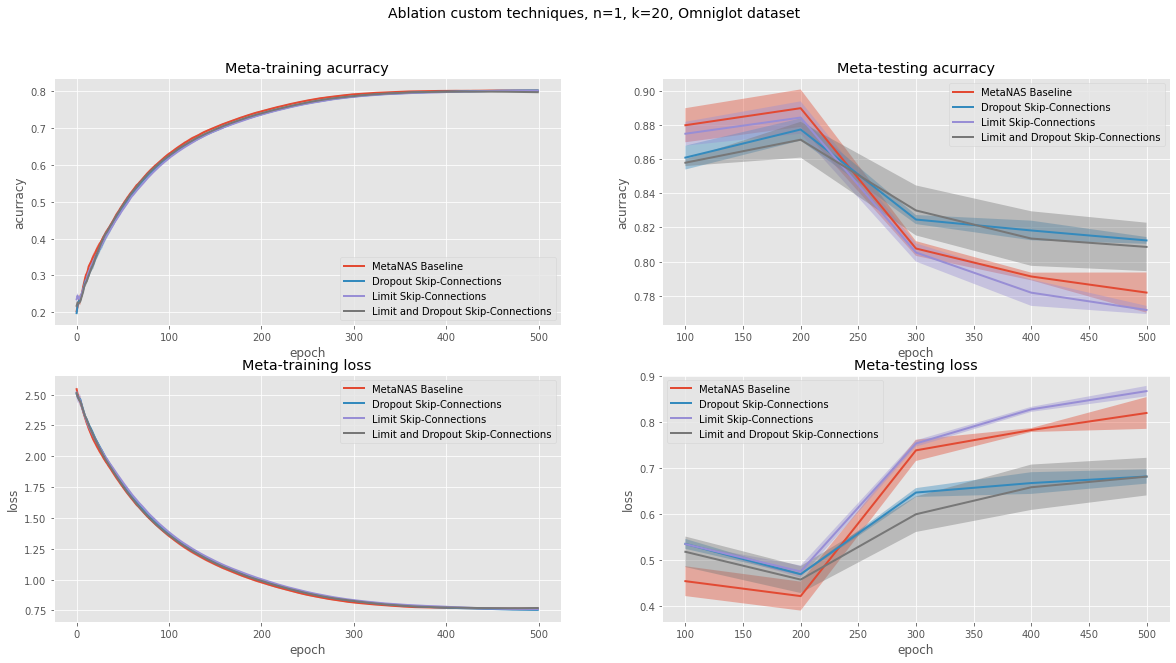

In [62]:
paths = [
    "omniglot_train_metanas",
    "omniglot_train_dropout",
    "omniglot_train_limit_sk", 
    "omniglot_train_dropout_limit_sk"
]

names = [
    "MetaNAS Baseline",
    "Dropout Skip-Connections",
    "Limit Skip-Connections",
    "Limit and Dropout Skip-Connections"
]


plot_accuracy_loss_multiple_seeds(base_path, paths, names, eval_every=[100, 100, 100, 100],
                   title="Ablation custom techniques, n=1, k=20, Omniglot dataset")

### **Tests with custom scripts**

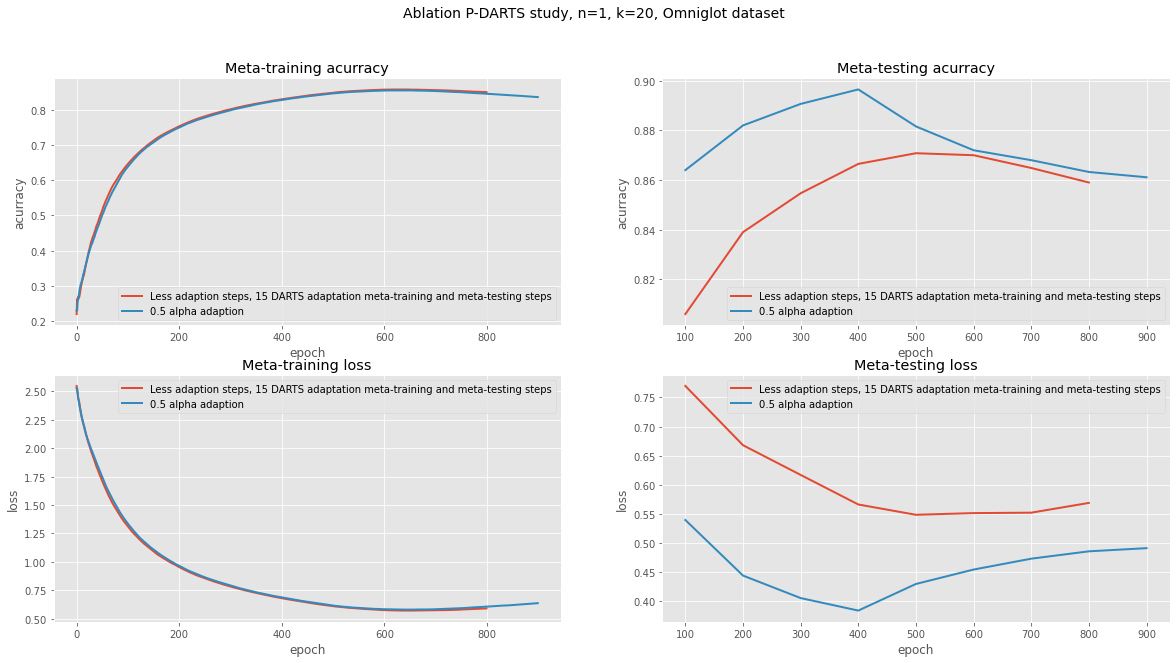

In [52]:
base_path = "/home/rob/Desktop/results/test/"

paths = [
#     "omniglot_train_metanas_epoch",
    "omniglot_train_metanas_less_adap",
    "omniglot_train_metanas_half_adap"
]

names = [
#     "2000 total epochs, 1000 warm-up epochs",
    "Less adaption steps, 15 DARTS adaptation meta-training and meta-testing steps",
    "0.5 alpha adaption"
]

eval_interval = [100, 100]

plot_accuracy_loss_multiple_seeds(base_path, paths, names, eval_every=eval_interval,
                   title="Ablation P-DARTS study, n=1, k=20, Omniglot dataset")

In [76]:
base_path = "/home/rob/Git/meta-fsl-nas/metanas/results/agent/"


path = "triplemnist_metanas_ppo_agent_metad2a"


path = os.path.join(base_path, path)
for p in glob.glob(f"{path}/*/experiment.pickle"):
    with (open(p, 'rb')) as f:
        res = pickle.load(f)
"test meta-testing accuracy: ", res['test_test_accu']

('test meta-testing accuracy: ', [0.7520000100135803])

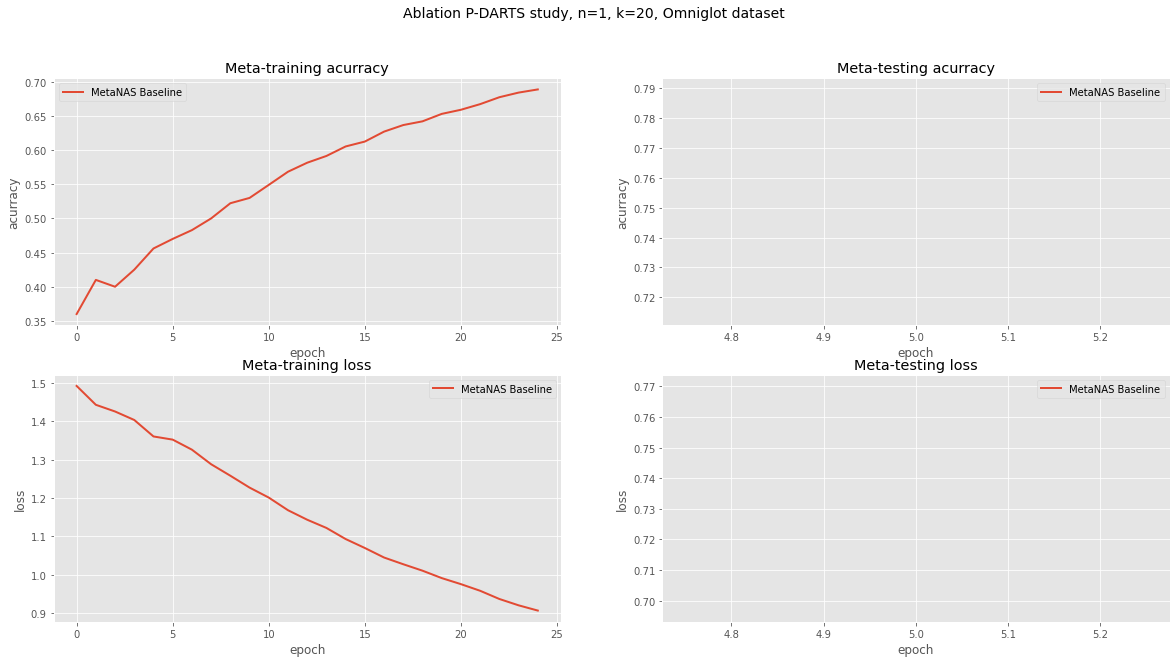

In [77]:
paths = [
    "triplemnist_metanas_ppo_agent_metad2a"
]

names = [
    "MetaNAS Baseline"]



plot_accuracy_loss_multiple_seeds(base_path, paths, names, eval_every=[5],
                   title="Ablation P-DARTS study, n=1, k=20, Omniglot dataset")

# Best ablation comparisons

---

*Dropout skip-connection, limit skip-connection and alpha regularization*



| 1-shot, 20-way Omniglot  |   |   | 3-shot, 20-way Omniglot  |   |   |
|--------------------------|---|---|--------------------------|---|---|
| **Seed 0**               |   |   | **Seed 0**               |   |   |
| MetaNAS (baseline)       | x |   | MetaNAS (baseline)       | x |   |
| Best ablation            |   | - | Best ablation            |   | - |
| **Seed 1**               |   |   | **Seed 1**               |   |   |
| MetaNAS (baseline)       | x |   | MetaNAS (baseline)       | - |   |
| Best ablation            |   | - | Best ablation            |   | - |


In [ ]:
# 3-shot, 20-way Omnitglot

paths = [
    "/home/rob/Git/meta-fsl-nas/metanas/results/baseline/omniglot_train_metanas_n3",
#     "/home/rob/Git/meta-fsl-nas/metanas/results/baseline/omniglot_n3_train_best",
]

names = [
    "MetaNAS Baseline",
    "MetaNAS+MaxW ..."
]

plot_accuracy_loss_multiple_seeds(paths, names,
                   title="Baseline comparison, n=3, k=20, Omniglot dataset")

In [ ]:
# 1-shot, 20-way Omniglot

| 3-shot, 20-way TripleMNIST  |   |   |
|-----------------------------|---|---|
| **Seed 0**                  |   |   |
| MetaNAS (baseline)          | x |   |
| Best ablation               |   | - |
| **Seed 1**                  |   |   |
| MetaNAS (baseline)          | - |   |
| Best ablation               |   | - |

In [ ]:

paths = [
    "/home/rob/Git/meta-fsl-nas/metanas/results/baseline/triplemnist_train_metanas_n3",
#     "/home/rob/Git/meta-fsl-nas/metanas/results/baseline/omniglot_n3_train_best",
    "/home/rob/Git/meta-fsl-nas/metanas/results/ablation/omniglot_train_dropout_limit_sk", 
]

names = [
    "MetaNAS Baseline",
    "MetaNAS+MaxW ..."
]

plot_accuracy_loss_multiple_seeds(paths, names,
                   title="Baseline comparison, n=3, k=20, TripleMNIST dataset")

## Transfer between datasets

---

| 3-shot, 20-way Transfer to TripleMNIST  |   |   |
|-----------------------------------------|---|---|
| **Seed 0**                              |   |   |
| MetaNAS (baseline)                      | - |   |
| Best ablation                           |   | - |
| **Seed 1**                              |   |   |
| MetaNAS (baseline)                      | - |   |
| Best ablation                           |   | - |


In [ ]:
paths_in = [
    "/home/rob/Git/meta-fsl-nas/metanas/results/baseline/omniglot_train_metanas_n3"
]

paths_out = [
#     "/home/rob/Git/meta-fsl-nas/metanas/results/baseline/triplemnist_train_metanas_n3",
#     "/home/rob/Git/meta-fsl-nas/metanas/results/transfer/triplemnist_train_n3",
    "/home/rob/Git/meta-fsl-nas/metanas/results/transfer/triplemnist_train_n3",
    "/home/rob/Git/meta-fsl-nas/metanas/results/transfer/triplemnist_dropout_limit_sk_n3_250"
]


matplotlib.rc('font', size = 20)

names = [
#     "MetaNAS test",
    "Baseline",
    "Limit and dropout skip-connections"
]

In [ ]:
paths_in = [
    "/home/rob/Git/meta-fsl-nas/metanas/results/baseline/omniglot_train_metanas_n3",
    "/home/rob/Git/meta-fsl-nas/metanas/results/transfer/triplemnist_train_n3_250",
    "/home/rob/Git/meta-fsl-nas/metanas/results/transfer/triplemnist_dropout_limit_sk_n3_250"
]

paths_out = [
    "/home/rob/Git/meta-fsl-nas/metanas/results/transfer/triplemnist_train_n3",
    "/home/rob/Git/meta-fsl-nas/metanas/results/transfer/triplemnist_train_n3_250",
    "/home/rob/Git/meta-fsl-nas/metanas/results/transfer/triplemnist_dropout_limit_sk_n3_250"
]


matplotlib.rc('font', size = 12)

names = [
    "Baseline",
    "sadas",
    "Limit and dropout skip-connections"
]

plot_accuracy_loss_transfer_seeds(paths_in, paths_out, names,
                   title="")
# Transfer comparison, n=3, k=20, Omniglot to TripleMNIST

In [ ]:
def plot_accuracy_loss_transfer_seeds(paths_in, paths_out, labels, every=100, title=""):
    def get_results(path):
        result = []
        for p in glob.glob(f"{path}/*/experiment.pickle"):
            with (open(p, 'rb')) as f:
                res = pickle.load(f)
                result.append(res)
        return result

    def plot_line_training(ax, result, indice, label, y_label):
        train_acc = np.array([np.array(m[indice]) for m in result])
        
        train_acc_mean = train_acc.mean(axis=0)
        print(f"indice:{indice}, label:{label}, test-test acc:{train_acc_mean[-1]}")
            
        len_epoch = len(np.array(result[0][indice]))
        train_acc_mean = train_acc.mean(axis=0)
        train_acc_std = train_acc.std(axis=0)
        print(len_epoch)
        x_axis_meta = np.array(range(train_acc_mean.shape[0]))
        if indice == "test_test_accu":
            if len_epoch == 250:
                test_spacing = np.linspace(50, 250,
                                   num=5, 
                                   retstep=50, dtype=np.int32)[0]
            else:
                test_spacing = np.linspace(100, 500,
                                           num=5, 
                                           retstep=100, dtype=np.int32)[0]
            ax.plot(test_spacing[:len(result[0][indice])], train_acc_mean, lw = 2, alpha = 1, label=label)
            ax.set_title(f"Meta-testing {y_label}")

        if indice == "train_test_accu":
            ax.plot(x_axis_meta, train_acc_mean, lw = 2, alpha = 1, label=label)
                
            ax.set_title(f"Meta-training {y_label}")
        ax.fill_between(x_axis_meta, train_acc_mean - train_acc_std,
                        train_acc_mean + train_acc_std, alpha = 0.4)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(y_label)
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc="best")
    
    results_in = [get_results(p) for p in paths_in]
    results_out = [get_results(p) for p in paths_out]
    
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))
    plt.subplots_adjust(hspace=0.3)
    plt.suptitle(title, fontsize=14)
    
    y_label = "acurracy"
    
    for i, res_in in enumerate(results_in):
#         for j, indice in enumerate(["train_test_accu", "train_test_loss"]):
        plot_line_training(ax[0], res_in, "train_test_accu", labels[i], y_label=y_label)
        
    for i, res_out in enumerate(results_out):
#         for j, indice in enumerate(["train_test_accu", "train_test_loss"]):
        plot_line_training(ax[1], res_out, "test_test_accu", labels[i], y_label=y_label) #train_test_accu
    
    

paths_in = [
    "/home/rob/Git/meta-fsl-nas/metanas/results/ablation/omniglot_train_power_cosine"
]

paths_out = [
    "/home/rob/Git/meta-fsl-nas/metanas/results/ablation/omniglot_train_power_cosine"
]

names = [
    "MetaNAS test"
]

---

In [8]:
def plot_single_run(paths, names, eval_every=5, title=""):
    results = []
    palette = sns.color_palette()
    palette

    for p in paths:
        with (open(p, 'rb')) as f:
            res = pickle.load(f)
            results.append(res)
    
    _, axes = plt.subplots(2, 2, figsize=(20, 10))
    plt.suptitle(title, fontsize=14)
    test_spacing = np.linspace(eval_every, len(results[0]['train_test_loss']),
                               num=len(results[0]['test_test_loss']), 
                               retstep=eval_every, dtype=np.int32)[0]

    for i, res in enumerate(results):
        color = palette.pop()
        axes[0, 0].set_title("Meta-training loss")
        axes[0, 0].plot(res['train_test_loss'], 'o-',
                        color=color, label=f"{names[i]} loss")
        axes[0, 0].set_ylabel("Loss")
        axes[0, 0].set_xlabel("Epochs")
        axes[0, 0].legend(loc="best")
        
        axes[0, 1].set_title("Meta-testing loss")
        axes[0, 1].plot(test_spacing[:len(res['test_test_loss'])],
                        res['test_test_loss'],  '^-', color=color,
                        label=f"{names[i]} loss")
        axes[0, 1].set_ylabel("Loss")
        axes[0, 1].set_xlabel("Epochs")
        axes[0, 1].legend(loc="best")

        axes[1, 0].set_title("Meta-training accuracy")
        axes[1, 0].plot(res['train_test_accu'], 'o-', color=color,
                        label=f"{names[i]} accuracy")
        axes[1, 0].set_ylabel("Accuracy")
        axes[1, 0].set_xlabel("Epochs")
        axes[1, 0].legend(loc="best")

        axes[1, 1].set_title("Meta-testing accuracy")
        axes[1, 1].plot(test_spacing[:len(res['test_test_accu'])],
                        res['test_test_accu'], '^-', color=color,
                        label=f"{names[i]} accuracy")
        axes[1, 1].set_ylabel("Accuracy")
        axes[1, 1].set_xlabel("Epochs")
        axes[1, 1].legend(loc="best")

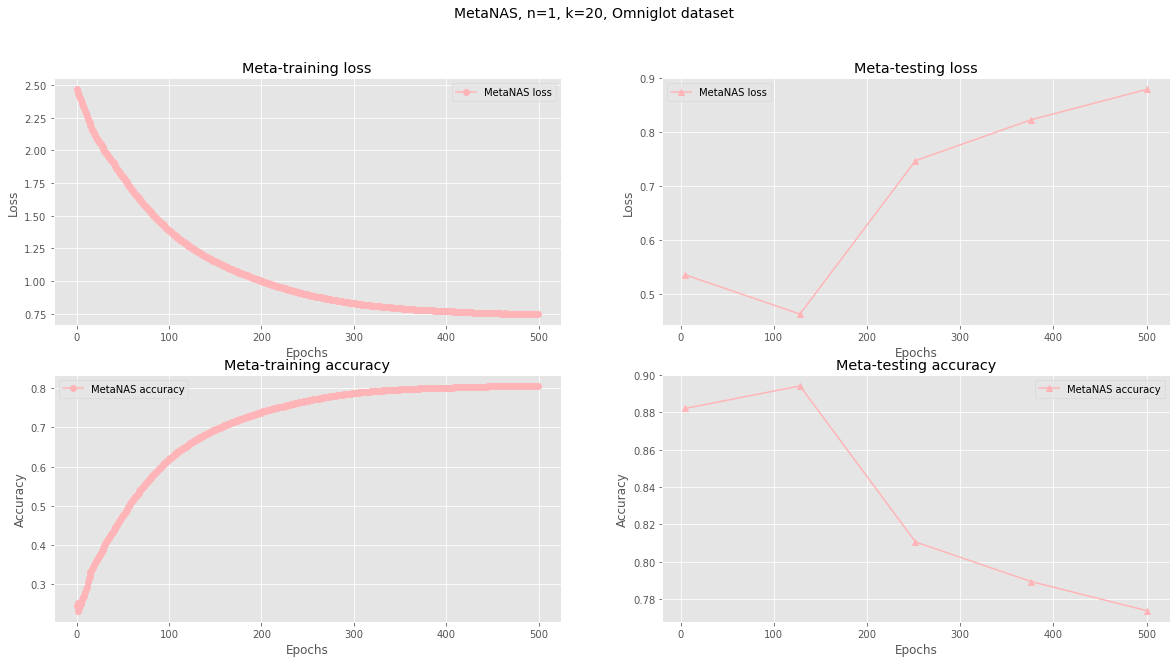

In [10]:
paths = [ "/home/rob/Desktop/thesis/ablation/omniglot_train_limit_sk/omniglot_train_limit_sk_1/experiment.pickle"]
names = ["MetaNAS"]

plot_single_run(paths, names, title="MetaNAS, n=1, k=20, Omniglot dataset")